In [23]:
# standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# word processing libraries
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet') 

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
new_word_list = ['flight', 'causing', 'encountered', 'difficult', 'proper', "n't", 'resulting', 'caused', 'making', 's', "'s", 'airline']
for word in new_word_list:
    stop_words.add(word)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\melov\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\melov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("Voice of Customer.csv").set_index('id')
print(f"length of dataset with NILs: {len(df)}")
df = df[df['voice of customer']!='NIL']
print(f"length of dataset w/o NILs: {len(df)}")
df

length of dataset with NILs: 14933
length of dataset w/o NILs: 2163


,satisfaction,satisfaction score,voice of customer
id,,,
72,neutral or dissatisfied,3,The emotional toll of the experience was overw...
93,neutral or dissatisfied,3,The extended wait for flight arrival was highl...
109,neutral or dissatisfied,4,The airline did not provide any updates during...
147,neutral or dissatisfied,4,The airline did not provide any compensation f...
244,neutral or dissatisfied,4,The airline charged excessive fees for baggage.
...,...,...,...
129647,neutral or dissatisfied,3,Faulty and unreliable onboard entertainment sy...
129709,neutral or dissatisfied,4,The cabin lacked proper disposal for used napk...
129721,neutral or dissatisfied,4,The airline lacked efficiency in managing flig...


In [29]:
snow_stem =  SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

def text_clean(text):
    text = word_tokenize(text.lower())
    cleaned_text = [lemmatizer.lemmatize((word), pos='v') for word in text if not word in stop_words]
    return ' '.join(cleaned_text)

df['voice of customer modified'] = df['voice of customer'].str.replace(',','')
df['voice of customer modified'] = df['voice of customer modified'].str.replace('.','')
df['voice of customer modified'] = df['voice of customer modified'].str.replace('!','')
df['voice of customer modified'] = df['voice of customer modified'].apply(text_clean)

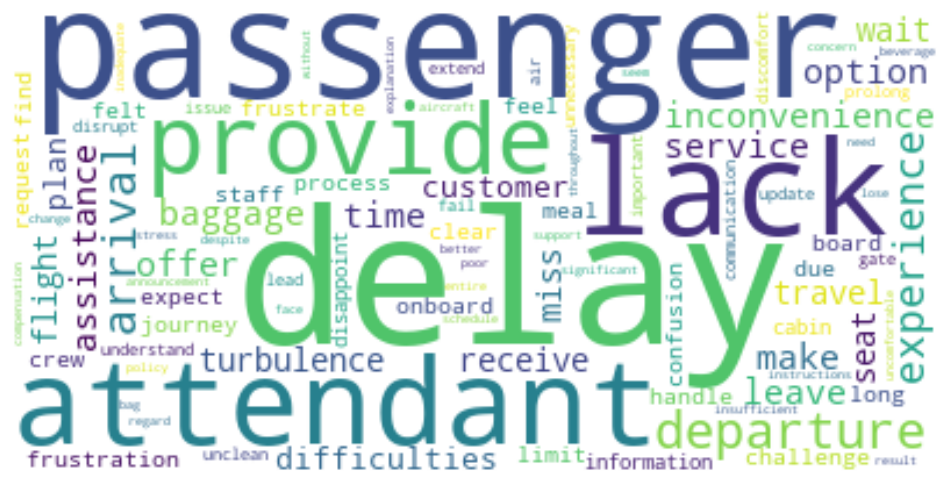

In [30]:
text = " ".join(df['voice of customer modified'])
word_cloud = WordCloud(collocations=False, background_color='white').generate(text)
plt.figure(figsize=(12,10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<Axes: xlabel='word'>

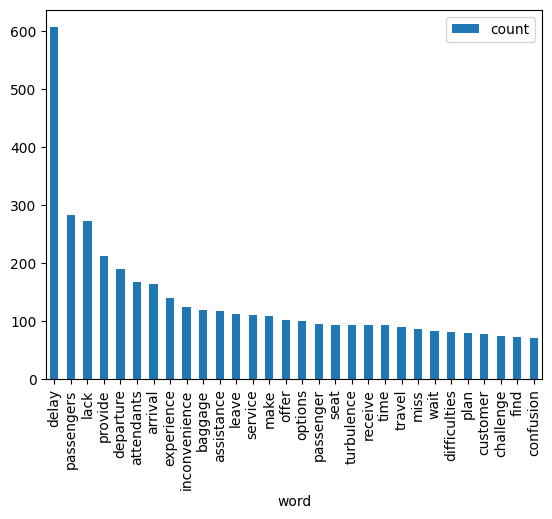

In [31]:
word_dict = {}
for word in text.split():
    if word not in word_dict.keys():
        word_dict[word] = 1
    else:
        word_dict[word] += 1

word_df = pd.DataFrame({'word':word_dict.keys(), 'count': word_dict.values()})
top_words = word_df.sort_values('count', ascending=False).head(30)
top_words.plot.bar(x='word')

- from word cloud and top 30 no. of words, we can see that certain topics could be delays, other passengers, attendants and their service, could be possible topic groups

- next we try to model different topics to better understand the different groups of complaints

# Topic Modeling

- [LDA topic modeling link](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)
- [BertTopic topic modeling link](https://www.youtube.com/watch?v=v3SePt3fr9g&ab_channel=PythonTutorialsforDigitalHumanities)

Using LDA topic modeling

In [53]:
# importing topic modeling libraries
from gensim.models import LdaMulticore
import gensim.corpora as corpora

In [63]:
# create a list of the different sentences
sentence_list = []
for sentence in df['voice of customer modified'].values:
    sentence = sentence.split()
    sentence_list.append(sentence)
print('first sentence')
print(sentence_list[:1][0][:10])
# convert sentences to show term frequency within each sentence
id2word = corpora.Dictionary(sentence_list)
corpus = [id2word.doc2bow(sentence) for sentence in sentence_list]
print('first sentence term frequency')
print(corpus[:1][0][:10])

first sentence
['emotional', 'toll', 'experience', 'overwhelm', 'felt', 'fail', 'meet', 'expectations']
first sentence term frequency
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]


In [64]:
# lda model
from pprint import pprint
num_topics = range(3, 10)
for num in num_topics:
    print(f'num of topics set: {num}')
    lda_model = LdaMulticore(corpus= corpus, id2word = id2word, num_topics=num)
    pprint(lda_model.print_topics())
    print("----------------------------------------------------------------")

# as we see from below, all topics that were modeled with different number of clusters had high similarity with delay being
# within each topic cluster 


num of topics set: 3
[(0,
  '0.036*"delay" + 0.027*"passengers" + 0.018*"provide" + 0.015*"lack" + '
  '0.013*"leave" + 0.011*"attendants" + 0.011*"experience" + 0.010*"arrival" + '
  '0.010*"departure" + 0.009*"assistance"'),
 (1,
  '0.029*"lack" + 0.016*"delay" + 0.015*"provide" + 0.013*"attendants" + '
  '0.010*"passenger" + 0.010*"assistance" + 0.010*"passengers" + 0.009*"fail" '
  '+ 0.009*"understand" + 0.008*"difficulties"'),
 (2,
  '0.054*"delay" + 0.019*"departure" + 0.015*"arrival" + 0.014*"time" + '
  '0.013*"passengers" + 0.013*"lack" + 0.012*"wait" + 0.011*"inconvenience" + '
  '0.010*"make" + 0.010*"turbulence"')]
----------------------------------------------------------------
num of topics set: 4
[(0,
  '0.044*"delay" + 0.018*"departure" + 0.016*"lack" + 0.015*"arrival" + '
  '0.014*"passengers" + 0.013*"attendants" + 0.011*"miss" + 0.011*"plan" + '
  '0.011*"make" + 0.011*"leave"'),
 (1,
  '0.038*"delay" + 0.025*"lack" + 0.019*"passengers" + 0.014*"options" + '
  '0.01

In [68]:
# importing libraries for analysis
import pyLDAvis.gensim
import pickle
import pyLDAvis
import os

In [115]:
# choosing number of topics to be 6 as it has the most unique cluster with no overlaps
final_num_topics = 66
lda_model = LdaMulticore(corpus= corpus, id2word = id2word, num_topics=final_num_topics)

In [116]:
if not os.path.exists('topic_modeling'):
    os.makedirs('topic_modeling')

pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./topic_modeling/ldavis_prepared_'+str(final_num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './topic_modeling/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
51     0.076946  0.120022       1        1  2.478486
10     0.013709  0.014919       2        1  2.252370
19     0.007063 -0.015106       3        1  2.156948
54     0.047002 -0.024370       4        1  2.135469
48    -0.031709  0.065383       5        1  2.056031
...         ...       ...     ...      ...       ...
44    -0.134558 -0.137988      62        1  1.042820
5      0.032852  0.025663      63        1  1.012092
43     0.089441 -0.030668      64        1  1.003849
32     0.049238  0.081977      65        1  0.967309
63    -0.094095  0.018741      66        1  0.960239

[66 rows x 5 columns], topic_info=           Term        Freq       Total Category  logprob  loglift
13        delay  534.000000  534.000000  Default  30.0000  30.0000
8       arrival  147.000000  147.000000  Default  29.0000  29.0000
2    experience  127.000000  127.000000  Default  28.0000  28.0000
30         lack  236.000000  236.000000  Default  27.0000  27.0000
18      baggage  109.000000  109.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
224     display    1.508683   29.384413  Topic66  -4.5142   1.6765
158       claim    1.508677   24.368455  Topic66  -4.5142   1.8637
166       clear    1.508674   58.598109  Topic66  -4.5142   0.9863
63      service    1.508671   99.599025  Topic66  -4.5142   0.4558
94        leave    1.508658  103.766377  Topic66  -4.5142   0.4148

[3892 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
390       1  0.040572       '
390       3  0.040572       '
390       4  0.081145       '
390       5  0.081145       '
390       6  0.081145       '
...     ...       ...     ...
230      37  0.140232   young
230      64  0.140232   young
230      65  0.140232   young
1326      3  0.354344  zipper
1326     13  0.354344  zipper

[9076 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[52, 11, 20, 55, 49, 28, 16, 22, 40, 9, 10, 39, 53, 34, 35, 32, 56, 43, 2, 46, 14, 26, 25, 36, 54, 51, 19, 38, 65, 1, 48, 15, 58, 7, 27, 47, 63, 21, 66, 17, 12, 18, 61, 37, 13, 42, 3, 59, 60, 31, 24, 57, 62, 29, 41, 5, 23, 4, 50, 8, 30, 45, 6, 44, 33, 64])

Using BertTopic

In [100]:
from bertopic import BERTopic

In [101]:
# as bertopic is able to handle noise in data, we do not need to remove stopwords so we re-import the data to be used again
df_bert = pd.read_csv("Voice of Customer.csv")
bert_text = list(df_bert[df_bert['voice of customer']!='NIL']['voice of customer'])
bert_text[0]

'The emotional toll of the experience was overwhelming, and I felt the airline had failed to meet my expectations.'

In [106]:
# initialise model
topic_model = BERTopic(embedding_model='all-MiniLM-L6-v2', language='english')
topics, probs = topic_model.fit_transform(bert_text)

In [114]:
topic_model.get_topic_info().to_csv('topic_modeling/bertopic_topics.csv')

In [108]:
topic_model.get_topic(0)

[('meal', 0.05560268372596186),
 ('options', 0.054941673465662644),
 ('food', 0.0394260664265688),
 ('any', 0.03878662463626946),
 ('offer', 0.03604271229163792),
 ('dietary', 0.03478777879863899),
 ('beverage', 0.029202584681224695),
 ('vegetarian', 0.026676424981199234),
 ('served', 0.024897996649119285),
 ('quality', 0.024450089513433748)]

In [109]:
topic_model.get_representative_docs(0)

["The airline didn't offer any gluten-free meal options, disregarding passengers with dietary restrictions.",
 'The airline did not provide any vegetarian meal options.',
 'The airline did not offer any vegetarian meal options.']

In [113]:
topic_df = pd.DataFrame({'topic': topics, 'voice of customer':bert_text}).merge(df_bert, on='voice of customer')
topic_df

,topic,voice of customer,id,satisfaction,satisfaction score
0,7,The emotional toll of the experience was overw...,72,neutral or dissatisfied,3
1,34,The extended wait for flight arrival was highl...,93,neutral or dissatisfied,3
2,-1,The airline did not provide any updates during...,109,neutral or dissatisfied,4
3,21,The airline did not provide any compensation f...,147,neutral or dissatisfied,4
4,26,The airline charged excessive fees for baggage.,244,neutral or dissatisfied,4
...,...,...,...,...,...
2158,50,Faulty and unreliable onboard entertainment sy...,129647,neutral or dissatisfied,3
2159,-1,The cabin lacked proper disposal for used napk...,129709,neutral or dissatisfied,4
2160,57,The airline lacked efficiency in managing flig...,129721,neutral or dissatisfied,4
2161,0,I encountered a delay in receiving my requeste...,129814,neutral or dissatisfied,4
